In [17]:
import utils
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import torch
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.out = nn.Linear(emb_size, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, word_id: int):
        x = self.emb(word_id)
        x = self.out(x)
        return F.log_softmax(x, dim=-1)
    
    def get_emb(self, word_id: torch.Tensor):
        return self.emb(word_id)


class Classifier(torch.nn.Module):
    def __init__(self, emb_size: int, num_hidden: int, hidden_size: int):
        super().__init__()
        self.start = nn.Linear(emb_size, hidden_size)
        self.hidden = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.end = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor):
        x = self.start(x)
        x = F.relu(x)
        for h in self.hidden:
            x = F.relu(h(x))
        x = self.end(x)
        x = torch.sigmoid(x)
        return x

def compute_emb(model: nn.Module, molecule: List[str], vocab: dict, device: torch.device) -> torch.Tensor:
    word_id = [vocab[w] for w in molecule]
    emb = model.get_emb(torch.tensor(word_id).to(device)).detach()
    return torch.mean(emb, dim=0)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('models/wdict.p', 'rb') as wdict_file:
    wdict = pickle.load(wdict_file)
emb_net = SkipGram(vocab_size=len(wdict), emb_size=300)
emb_net.load_state_dict(torch.load('models/emb.pt'))
emb_net = emb_net.to(device)
raw_data, ys = utils.import_smiles('data/HIV.csv', skiprow=True, include_y=True)

In [14]:
dataset = []
for molecule, y in zip(raw_data, ys):
    dataset.append((compute_emb(emb_net, molecule, wdict, device), torch.tensor(y).to(device, dtype=torch.float)))

In [24]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
classifier = Classifier(300, 3, 1024).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) 

In [25]:
losses = []
for epoch in range(100):
    epoch_loss = []
    with tqdm() as pbar:
        pbar.set_description(f'Epoch {epoch}')
        for embedding, y in dataloader:
            optimizer.zero_grad()
            out = classifier(embedding)
            loss = F.binary_cross_entropy(torch.squeeze(out), y)
            loss.backward()
            optimizer.step()
            pbar.update(1)
            epoch_loss.append(loss.item())
        losses.append(np.mean(epoch_loss))
        pbar.set_postfix({'loss': np.mean(epoch_loss)})

Epoch 0: : 41it [00:00, 77.21it/s, loss=0.21]
Epoch 1: : 41it [00:00, 82.50it/s, loss=0.147]
Epoch 2: : 41it [00:00, 72.85it/s, loss=0.144]
Epoch 3: : 41it [00:00, 82.66it/s, loss=0.14]
Epoch 4: : 41it [00:00, 82.99it/s, loss=0.139]
Epoch 5: : 41it [00:00, 82.63it/s, loss=0.136]
Epoch 6: : 41it [00:00, 82.70it/s, loss=0.134]
Epoch 7: : 41it [00:00, 82.40it/s, loss=0.134]
Epoch 8: : 41it [00:00, 83.36it/s, loss=0.13]
Epoch 9: : 41it [00:00, 83.15it/s, loss=0.13]
Epoch 10: : 41it [00:00, 76.64it/s, loss=0.128]
Epoch 11: : 41it [00:00, 81.50it/s, loss=0.125]
Epoch 12: : 41it [00:00, 85.95it/s, loss=0.124]
Epoch 13: : 41it [00:00, 85.06it/s, loss=0.124]
Epoch 14: : 41it [00:00, 85.24it/s, loss=0.122]
Epoch 15: : 41it [00:00, 85.42it/s, loss=0.119]
Epoch 16: : 41it [00:00, 84.02it/s, loss=0.119]
Epoch 17: : 41it [00:00, 84.89it/s, loss=0.118]
Epoch 18: : 41it [00:00, 85.24it/s, loss=0.115]
Epoch 19: : 41it [00:00, 84.36it/s, loss=0.116]
Epoch 20: : 41it [00:00, 84.46it/s, loss=0.116]
Epoch 

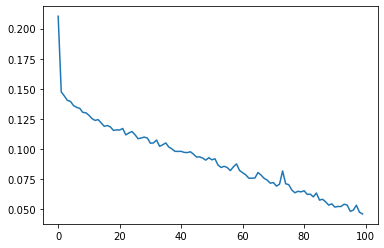

In [26]:
plt.plot(losses)